# Read Datasets and EDA

In [10]:
import pandas as pd

# Read datasets
df = pd.read_csv('bbc-news-data.csv', sep='\t')
df.sample(10)

,category,filename,title,content
1295,politics,400.txt,Ex-PM Lord Callaghan dies aged 92,Former Labour prime minister Lord Callaghan h...
824,entertainment,315.txt,Hoffman hits out over modern film,Hollywood legend Dustin Hoffman has hit out a...
1030,politics,135.txt,Blair says UK tsunami aid to soar,Tony Blair has predicted the British Governme...
1905,tech,082.txt,Games firms 'face tough future',UK video game firms face a testing time as th...
969,politics,074.txt,BNP leader Nick Griffin arrested,The leader of the British National Party has ...
1175,politics,280.txt,Blair sees greater Bush consensus,George W Bush will display a more consensual ...
740,entertainment,231.txt,Three DJs replace Peel radio show,The late John Peel's BBC Radio 1 show is to b...
819,entertainment,310.txt,BBC denies Blackadder TV comeback,The BBC has said there are no plans in the pi...
181,business,182.txt,Weak data buffets French economy,A batch of downbeat government data has cast ...
18,business,019.txt,India widens access to telecoms,India has raised the limit for foreign direct...


In [11]:
# Check data shape
df.shape

(2225, 4)

In [12]:
# Check null data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   filename  2225 non-null   object
 2   title     2225 non-null   object
 3   content   2225 non-null   object
dtypes: object(4)
memory usage: 69.7+ KB


In [13]:
# Check duplicated data
df.duplicated().sum()

0

In [14]:
# Remove duplicated data
df = df[~df.duplicated()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2225 entries, 0 to 2224
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   filename  2225 non-null   object
 2   title     2225 non-null   object
 3   content   2225 non-null   object
dtypes: object(4)
memory usage: 86.9+ KB


In [15]:
# Check counts of each category whether data are balanced
df.category.value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

In [16]:
# Drop title and filename columns
df = df.drop(columns=['filename', 'title'])
df

,category,content
0,business,Quarterly profits at US media giant TimeWarne...
1,business,The dollar has hit its highest level against ...
2,business,The owners of embattled Russian oil giant Yuk...
3,business,British Airways has blamed high fuel prices f...
4,business,Shares in UK drinks and food firm Allied Dome...
...,...,...
2220,tech,BT is introducing two initiatives to help bea...
2221,tech,Computer users across the world continue to i...
2222,tech,A new European directive could put software w...
2223,tech,The man making sure US computer networks are ...


In [17]:
# Use one hot encoding because label is categorical
label = pd.get_dummies(df.category)
new_df = pd.concat([df, label], axis=1)
new_df = new_df.drop(columns='category')
new_df

,content,business,entertainment,politics,sport,tech
0,Quarterly profits at US media giant TimeWarne...,1,0,0,0,0
1,The dollar has hit its highest level against ...,1,0,0,0,0
2,The owners of embattled Russian oil giant Yuk...,1,0,0,0,0
3,British Airways has blamed high fuel prices f...,1,0,0,0,0
4,Shares in UK drinks and food firm Allied Dome...,1,0,0,0,0
...,...,...,...,...,...,...
2220,BT is introducing two initiatives to help bea...,0,0,0,0,1
2221,Computer users across the world continue to i...,0,0,0,0,1
2222,A new European directive could put software w...,0,0,0,0,1
2223,The man making sure US computer networks are ...,0,0,0,0,1


# Create function to clean text

In [18]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [19]:
# Data Cleaning
def clean_text(text):
    text = re.sub("[^a-zA-Z]"," ",text)
    text = ' '.join(text.split())
    text = text.lower()
    return text
new_df['content'] = new_df['content'].apply(clean_text)

In [20]:
# Stopwords removal
stop_words = set(stopwords.words('english'))
# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)
new_df['content'] = new_df['content'].apply(remove_stopwords)

In [21]:
# Word lemmitization
lemmatizer = WordNetLemmatizer()
def lemmatization(text):
    lem = [lemmatizer.lemmatize(w) for w in text.split()]
    return ' '.join(lem)
new_df['content'] = new_df['content'].apply(lemmatization)

# Prepraring to train the datasets

In [22]:
# Get value of attribute and label from the df
content = new_df['content'].values
label = new_df.values[:, 1:].astype(int)

In [23]:
# Split data train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(content, label, test_size=0.2)

In [55]:
# Do tokenizing, sequencing and also padding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=20000, oov_token='x')
tokenizer.fit_on_texts(X_train)

train_sequence = tokenizer.texts_to_sequences(X_train)
test_sequence = tokenizer.texts_to_sequences(X_test)

train_padded = pad_sequences(train_sequence)
test_padded = pad_sequences(test_sequence)

# Initiate LSTM model and begin training

In [56]:
# Iniate LSTM model 
import tensorflow as tf
from keras import optimizers

v = len(tokenizer.word_index)

model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(input_dim=v+1, output_dim=16),
                             tf.keras.layers.AveragePooling1D(),
                             tf.keras.layers.LSTM(64),
                             tf.keras.layers.Dense(128, activation='relu'),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(5, activation='softmax')                             
])
adam = tf.optimizers.Adam(learning_rate=0.001, decay=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 16)          359920    
                                                                 
 average_pooling1d_7 (Averag  (None, None, 16)         0         
 ePooling1D)                                                     
                                                                 
 lstm_7 (LSTM)               (None, 64)                20736     
                                                                 
 dense_19 (Dense)            (None, 128)               8320      
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 dense_20 (Dense)            (None, 5)                 645       
                                                      

In [57]:
# Initiate callback functions
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.95 and logs.get('val_accuracy') > 0.90):
      print("\nAccuracy already reached >90%!")
      self.model.stop_training = True
callbacks = myCallback()

In [58]:
# Begin training
num_epochs = 30
hist = model.fit(train_padded, y_train, epochs=num_epochs,
                    validation_data=(test_padded, y_test), verbose=2, callbacks=callbacks, batch_size=128, validation_split=0.2)

Epoch 1/30
12/12 - 11s - loss: 1.6081 - accuracy: 0.2198 - val_loss: 1.6028 - val_accuracy: 0.2275 - 11s/epoch - 945ms/step
Epoch 2/30
12/12 - 9s - loss: 1.5983 - accuracy: 0.2760 - val_loss: 1.5824 - val_accuracy: 0.2444 - 9s/epoch - 768ms/step
Epoch 3/30
12/12 - 9s - loss: 1.5164 - accuracy: 0.3771 - val_loss: 1.3519 - val_accuracy: 0.4860 - 9s/epoch - 770ms/step
Epoch 4/30
12/12 - 9s - loss: 1.5049 - accuracy: 0.4101 - val_loss: 1.4311 - val_accuracy: 0.4354 - 9s/epoch - 768ms/step
Epoch 5/30
12/12 - 9s - loss: 1.3737 - accuracy: 0.4431 - val_loss: 1.2740 - val_accuracy: 0.5000 - 9s/epoch - 778ms/step
Epoch 6/30
12/12 - 9s - loss: 1.1809 - accuracy: 0.4909 - val_loss: 1.1159 - val_accuracy: 0.4438 - 9s/epoch - 781ms/step
Epoch 7/30
12/12 - 9s - loss: 1.0557 - accuracy: 0.5471 - val_loss: 1.0333 - val_accuracy: 0.5590 - 9s/epoch - 762ms/step
Epoch 8/30
12/12 - 9s - loss: 0.9202 - accuracy: 0.5864 - val_loss: 0.9335 - val_accuracy: 0.6208 - 9s/epoch - 770ms/step
Epoch 9/30
12/12 - 9s 

# Plot accuracy and loss

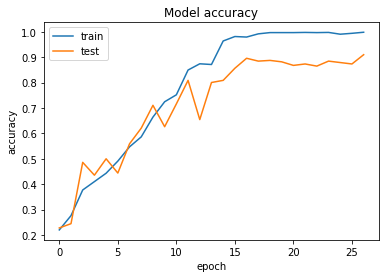

In [59]:
import matplotlib.pyplot as plt
# Create function to plot training graph:
def plot_graph(history, history2, title, xlabel, ylabel):
  plt.plot(hist.history[history])
  plt.plot(hist.history[history2])
  plt.title(title)
  plt.ylabel(xlabel)
  plt.xlabel(ylabel)
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

# Plot accuracy
plot_graph('accuracy', 'val_accuracy', 'Model accuracy', 'accuracy', 'epoch')


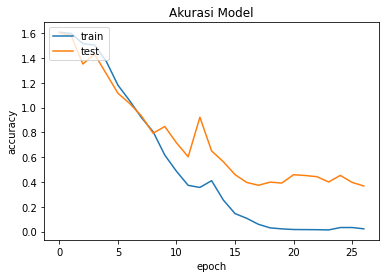

In [60]:
# Plot loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Prediction Test

In [61]:
# Prepare text to feed to model
sentence = ["Cristiano Ronaldo just score a goal"]
sentence_seq = tokenizer.texts_to_sequences(sentence)
sentence_pad = pad_sequences(sentence_seq)

# Try prediction
prediction = model.predict(sentence_pad)

In [62]:
prediction

array([[0.01064247, 0.38238242, 0.00899464, 0.587567  , 0.0104135 ]],
      dtype=float32)